<a href="https://colab.research.google.com/github/linhtrinh213/Interpretable_VAE_TF_regulons/blob/main/base_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Note
To work productively with gg colab (12 hours session):
1. Mount gg drive:
from google.colab import drive
drive.mount('/content/drive')
2. Then save or load files: model.save('/content/drive/MyDrive/my_model.h5')

- Export code (notebook) frequently (or save a copy in github)
- Save model checkpoints/variables...


To do next:
1. Incorporate TFs into the model
2. train 2 base models (one for the control and one for the stimulated)
(-> observe the weights)
3. retrain many times

## 1: Loading neccessities

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#### Setup ####
# install and import required packages
!pip install scanpy
#!pip install decoupler
#!pip install omnipath

import torch; torch.manual_seed(100)
import torch.nn as nn
import torch.utils
import torch.distributions
import torchvision
from torchvision import datasets, transforms
import math
import numpy as np
np.random.seed(100)
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import scanpy as sc
from collections import OrderedDict
from collections import Counter
import pandas as pd

# select the right device, depending on whether your Colab runs on GPU or CPU
### IMPORTANT: we recommend to change your runtime to GPU, otherwise the training takes much longer
device = 'mps'


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


## 2: The data

In [8]:
# Load data and use Scanpy to convert it into AnnData
PBMC_train = sc.read_h5ad("/content/drive/MyDrive/WORK/Turing Project/Interpretable_VAE/data/PBMC_train.h5ad")
regulons = pd.read_csv('/content/drive/MyDrive/WORK/Turing Project/Interpretable_VAE/data/regulons.csv')

In [ ]:
# Take a look at the data
print(PBMC_train) #the data is stored as an anndata object
print(Counter(PBMC_train.obs["cell_type"])) #summary of cell types
print(Counter(PBMC_train.obs["condition"])) #summary of conditions
# 13515 observation: cells (.obs attribute)
# gene expression data: .X (sparse matrix)
# annotations for the variables (genes) in the .var attribute
# the attribute have specific features that can be accessed using squared bracktets

AnnData object with n_obs × n_vars = 13515 × 6998
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'
Counter({'CD4T': 4452, 'FCGR3A+Mono': 2881, 'CD14+Mono': 2049, 'B': 1448, 'NK': 931, 'CD8T': 892, 'Dendritic': 862})
Counter({'stimulated': 7109, 'control': 6406})


In [9]:
# devide data into control and stimulated

# Subset for a specific condition, e.g., "control"
PBMC_control = PBMC_train[PBMC_train.obs["condition"] == "control"].copy()

# Another example for "treated"
PBMC_stimulated = PBMC_train[PBMC_train.obs["condition"] == "stimulated"].copy()


In [10]:
# Define Encoder:
class Encoder(nn.Module):
    def __init__(self, latent_dims, input_dims, dropout, z_dropout): #dropout between the dense layers, z_dropout define the dropout rates between the encoder/latent space
        super(Encoder, self).__init__() #run the initialize code from nn.Module -> this class behaves like a Pytorch model
        self.encoder = nn.Sequential(
                                     nn.Linear(input_dims, 800),
                                     nn.ReLU(),
                                     nn.Dropout(p = dropout),
                                     nn.Linear(800, 800),
                                     nn.ReLU(),
                                     nn.Dropout(p = dropout))  #two layer, fully connected encoder with dropout

        # outputs mean vector u
        self.mu = nn.Sequential(nn.Linear(800, latent_dims), # the 800 neurons in the second layers -> latent space
                                nn.Dropout(p = z_dropout))
        # outputs standard variance
        self.sigma = nn.Sequential(nn.Linear(800, latent_dims),
                                   nn.Dropout(p = z_dropout))

        self.N = torch.distributions.Normal(0, 1)  # define Gaussian distribution for each input
        self.N.loc = self.N.loc.to(device) # move to the right device
        self.N.scale = self.N.scale.to(device)
        self.kl = 0 # place holder for storing KL divergence (regularization term)
        # KL measures how far the learned Gaussian is from the standard normal (0,1) -> this is a regularization term in VAE
    def forward(self, x):
        x = self.encoder(x) # pass the data to the encoder
        mu =  self.mu(x) # predict mean vector
        sigma = torch.exp(self.sigma(x)) # predict standard var exp for numeric stability
        z = mu + sigma*self.N.sample(mu.shape)  # Sample z using reparameterization trick

        self.kl = (0.5*sigma**2 + 0.5*mu**2 - torch.log(sigma) - 1/2).sum() #calculation of kullback-leibler divergence

        return z # output is the sampled latent vector


## 3: regulons and create the mask

To achieve interpretability through model's decoder:
1. one-layer decoder: every latent var is directly connected to the output var
2. linear decoder: no activation function in the decoder
3. positive decoder: restrict the decoder weights to positive values (all negative weights = 0) (*why not - weight?, cant it be for inhibition?)
=> for this project: TF: It can be negative!
4. sparse decoder: latent node = TF, which only connect to certain genes


- How do we do that?
++ mask M: define decoder connections. Rows = genes. Columns = TF. If TF j has an effect on gene i -> the corresponding entry in the matrix M(i,j) contains the value 1. ??: has an effect = activate AND inhibit, or only activate?
So mask M: only defines which latent node **connect** to which decoder node, and the weights will learn + or - (activation or inhibition, or at least thats what we expect).
++ mask M: also includes fully connected nodes (all values = 1) -> for better data reconstruction and compensates for connections that are missing

In [ ]:
# processed regulons
#import decoupler as dc
#regulons = dc.get_collectri(organism='human', split_complexes=False)
# CollecTRI netork: a curated collection of TFs and their transcriptional targets
# spilt_complexes: keep or spilt complexes into subunits
# weight: 1 is activation. -1 is inhibition
# raw regulons
#import omnipath as op
#op.interactions.CollecTRI.get(genesymbols=True, organism=9606L, loops=True)#

In [ ]:
regulons.target.unique()

<StringArray>
[    'BAX',    'BCL2',    'BCL6',   'CCND2',  'CDKN1A',    'CSF1',   'FOXO3',
     'JUN',    'PIM1',    'TP53',
 ...
  'RNF114',   'ETNK1',    'CHL1',    'DSC1', 'GPRASP1',   'MAGI2',  'REC114',
   'SYNJ1',   'TCP11', 'PIK3AP1']
Length: 6627, dtype: string

In [11]:
import pandas as pd
import numpy as np

def create_mask(adata, regulons, add_nodes:int=10, sep = "\t"):
    """
    Initialize mask M that specifies which latent nodes connect to which decoder nodes.
    Args:
        adata (Anndata): Scanpy single-cell object, we will store the computed mask and the names of the biological processes there
        regulons: which TFs affected which genes
        add_nodes (int): Additional latent nodes for capturing additional variance
    Return:
        adata (Anndata): Scanpy single-cell object that now stores the computed mask and the names of biological processes (in the .uns["_vega"] attribute)
        mask (array): mask M that specifies whether a gene is included in the gene set of a pathway (value one) or not (value zero)
    """

    # Create the mask
    # 1. Get unique genes (targets) and TFs (sources)
    genes = regulons['target'].unique()
    tfs = regulons['source'].unique()

    # get their names and the corresponding sub‐mask
    selected_tfs  = ["STAT1", "STAT2", "STAT3","STAT4","STAT5A","STAT5B","STAT6","IRF1","IRF2","IRF3","IRF4","IRF5","IRF6","IRF7","IRF8","IRF9","NFKB","AP1","MYC","TP53"]

    # 2. Initialize matrix M with zeros
    M = pd.DataFrame(0, index=genes, columns=tfs)

    # 3. Set M[i,j] = 1 where the gene i is affected by TF j
    for _, row in regulons.iterrows(): # for each row in regulons
        M.loc[row['target'], row['source']] = 1 #the corresponding genes, TF box = 1

    M = M.loc[:, selected_tfs]  # if M is a pandas DataFrame

    # Add unannotated nodes
    vec = np.ones((M.shape[0], add_nodes))
    M = np.hstack((M, vec))

    adata.uns['_vega'] = dict() #create attribute "_vega" to store the mask and pathway information
    adata.uns['_vega']['mask'] = M
    adata.uns['_vega']['TFs'] = list(tfs) + ['UNANNOTATED_'+str(k) for k in range(add_nodes)]

    return adata, M

In [12]:
# apply the create_mask function
PBMC_control, mask_ctr = create_mask(PBMC_control,regulons , add_nodes=1)
PBMC_stimulated, mask_sti  = create_mask(PBMC_stimulated,regulons , add_nodes=1)

In [13]:
mask_ctr.shape

(6627, 21)

## 4: Decoder

- First, the genes will be filtered (take only the genes that appear in the mask AND our data, then filter out all genes that only contain 0 (non-relevant to TFs). THe gens will be filtered out both in the mask AND the PBMC data (otherwise error)
- Then, define decoder layer


In [50]:
#---# filter the genes in mask
# define names to filter genes for PBMC in the next chunk
mask_ctr_df = pd.DataFrame(mask_ctr, index= regulons.target.unique())
# list of genes in the regulons list and in our pbmc data
genes_mask = np.array(regulons.target.unique()) # genes in regulons list
pbmc_genes = np.array(PBMC_train.var_names) # genes in OUR data
# Create boolean mask of which genes are in PBMC_train
keep = np.isin(genes_mask, pbmc_genes)
# Apply the filter
filtered_mask_ctr_df = mask_ctr_df.loc[keep, :]
filtered_mask_sti_df = mask_ctr_df.loc[keep, :]

# count 0 (the rows in which all genes are 0 are filtered out) (careful: have to account for the last node that are fully connected)
# Count non-zero elements per row
non_zero_count = np.count_nonzero(filtered_mask_ctr_df, axis=1)

# Filter: keep rows with at least 2 non-zero elements
filtered_mask_ctr_df = filtered_mask_ctr_df[non_zero_count >= 2]

In [51]:
filtered_mask_ctr_df

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
BCL2,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
CCND2,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
CSF1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
JUN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
PIM1,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZMAT3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
ZNF346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
ZNF611,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
ZNHIT2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [52]:
filtered_mask_ctr_df.index

Index(['BCL2', 'CCND2', 'CSF1', 'JUN', 'PIM1', 'TP53', 'HBB', 'APOE', 'TNF',
       'ABCB1',
       ...
       'TSPYL2', 'TUBB2A', 'ULBP2', 'YPEL3', 'ZFP37', 'ZMAT3', 'ZNF346',
       'ZNF611', 'ZNHIT2', 'ZSCAN25'],
      dtype='object', length=1072)

In [24]:
# filter the genes in PBMC data
PBMC_control_filtered = PBMC_control[:, filtered_mask_ctr_df.index].copy()

In [53]:
filtered_mask_ctr_df

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
BCL2,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
CCND2,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
CSF1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
JUN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
PIM1,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZMAT3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
ZNF346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
ZNF611,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
ZNHIT2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [54]:
# convert pandas back to numpy array to use for downstream steps
filtered_mask_ctr = filtered_mask_ctr_df.to_numpy()

In [28]:
# define VEGA's decoder
class DecoderVEGA(nn.Module):
  """
  Define VEGA's decoder (sparse, one-layer, linear, positive)
  """
  def __init__(self,mask):
        super(DecoderVEGA, self).__init__()

        self.sparse_layer = nn.Sequential(SparseLayer(mask)) # we define the architecture of the decoder below with the class "SparseLayer"
        # This decoder only has 1 layer (Sparse)!!!

  def forward(self, x):
    z = self.sparse_layer(x.to(device))
    return(z)

# define a class SparseLayer, that specifies the decoder architecture (sparse connections based on the mask)
class SparseLayer(nn.Module):
  def __init__(self, mask):
        """
        Extended torch.nn module which mask connection
        """
        super(SparseLayer, self).__init__()

        self.mask = nn.Parameter(torch.tensor(mask, dtype=torch.float).t(), requires_grad=False)
        self.weight = nn.Parameter(torch.Tensor(mask.shape[1], mask.shape[0]))
        self.bias = nn.Parameter(torch.Tensor(mask.shape[1]))
        self.reset_parameters()

        # mask weight
        self.weight.data = self.weight.data * self.mask

  def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)

  def forward(self, input):
        # See the autograd section for explanation of what happens here
        return SparseLayerFunction.apply(input, self.weight, self.bias, self.mask)
        # OUTPUT of the decoder



# defines a custom forward and backward pass
class SparseLayerFunction(torch.autograd.Function):
    """
    We define our own autograd function which masks it's weights by 'mask'.
    For more details, see https://pytorch.org/docs/stable/notes/extending.html
    """

    # Note that both forward and backward are @staticmethods
    @staticmethod
    def forward(ctx, input, weight, bias, mask):
        # enforce the forward connection between latent and next layer to be sparse
        weight = weight * mask # change weight to 0 where mask == 0
        #calculate the output
        output = input.mm(weight.t()) # output = input × weight.T  (torch.mm : matrix multiplication)
        # IMPORTANT!!!
        # input = latent: has the dim (batch_size, latent_dim)
        #-> mask has the dim: (input_dim, latent_dim) -> transpose (latent_dim, input_dim) (input here this the original input, not the latent vector)
        # output: (batch_size, input_dim)  = same dimension with OUR input
        output += bias.unsqueeze(0).expand_as(output) # Add bias to all values in output
        ctx.save_for_backward(input, weight, bias, mask)
        return output

    @staticmethod
    def backward(ctx, grad_output): # define the gradient formula
        # compute gradient for backpropagation
        input, weight, bias, mask = ctx.saved_tensors
        grad_input = grad_weight = grad_bias = grad_mask = None

        # These needs_input_grad checks are optional and only to improve efficiency
        if ctx.needs_input_grad[0]:
            grad_input = grad_output.mm(weight)
            # grad_input: how the loss changes with respect to the input
        if ctx.needs_input_grad[1]:
            grad_weight = grad_output.t().mm(input) # how the loss changes with respect to weight
            grad_weight = grad_weight * mask # change grad_weight to 0 where mask == 0  (enforce the mask even in backward pass)
        if ctx.needs_input_grad[2]:
            grad_bias = grad_output.sum(0).squeeze(0)

        return grad_input, grad_weight, grad_bias, grad_mask


## 5: Training the model

In [29]:
# define class that combine encoder and decoder
class VEGA(nn.Module):
    def __init__(self, latent_dims, input_dims, mask, dropout = 0.3, z_dropout = 0.3):
        super(VEGA, self).__init__()
        self.encoder = Encoder(latent_dims, input_dims, dropout, z_dropout) # we use the same encoder as before (two-layer, fully connected, non-linear)
        self.decoder = DecoderVEGA(mask)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [30]:
#training loop
def trainVEGA(vae, data, epochs=30, beta = 0.0001, learning_rate = 0.01):
    opt = torch.optim.Adam(vae.parameters(), lr = learning_rate, weight_decay = 5e-4)
    vae.train() #train mode
    losses = []
    klds = []
    mses = []

    for epoch in range(epochs):
        loss_e = 0
        kld_e = 0
        mse_e = 0

        for x in data:
            x = x.to(device)
            opt.zero_grad()
            x_hat = vae(x)
            mse = ((x - x_hat)**2).sum()
            kld = beta* vae.encoder.kl
            loss = mse +  kld # loss calculation
            loss.backward()
            opt.step()
            loss_e += loss.to('cpu').detach().numpy()
            kld_e += kld.to('cpu').detach().numpy()
            mse_e += mse.to('cpu').detach().numpy()

        losses.append(loss_e/(len(data)*128))
        klds.append(kld_e/(len(data)*128))
        mses.append(mse_e/(len(data)*128))

        print("epoch: ", epoch, " loss: ", loss_e/(len(data)*128))

    return vae, losses, klds, mses

In [31]:
# train the model for control
PBMC_controlX = torch.utils.data.DataLoader(PBMC_control_filtered.X.toarray(), batch_size=128) #set up the training data in the right format
PBMC_stimulatedX = torch.utils.data.DataLoader(PBMC_stimulated.X.toarray(), batch_size=128) #set up the training data in the right format

In [32]:
import torch

# NOTE: In Runtime, Change type (hardware accelerator) -> GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [66]:
# train the model for control
vega_ctr = VEGA(latent_dims= filtered_mask_ctr.shape[1], input_dims = filtered_mask_ctr.shape[0], mask = filtered_mask_ctr.T, z_dropout = 0.1, dropout = 0.2).to(device) # input_dim should be the
# model training
vega_ctr, vega_losses_ctr, vega_klds_ctr, vega_mses_ctr = trainVEGA(vega_ctr, PBMC_controlX,epochs = 40, beta = 0.00001) #takes about 2 mins on GPU # change beta!!!
# gotta change dropout rate as well otherwise its too instable

epoch:  0  loss:  169.64748
epoch:  1  loss:  87.37096
epoch:  2  loss:  84.15119
epoch:  3  loss:  80.897644
epoch:  4  loss:  79.73702
epoch:  5  loss:  78.095116
epoch:  6  loss:  77.72229
epoch:  7  loss:  77.31809
epoch:  8  loss:  76.769394
epoch:  9  loss:  76.2019
epoch:  10  loss:  76.24429
epoch:  11  loss:  75.83963
epoch:  12  loss:  75.60139
epoch:  13  loss:  75.465454
epoch:  14  loss:  75.287926
epoch:  15  loss:  75.4219
epoch:  16  loss:  75.54733
epoch:  17  loss:  75.05117
epoch:  18  loss:  74.16263
epoch:  19  loss:  73.83484
epoch:  20  loss:  73.70192
epoch:  21  loss:  73.55178
epoch:  22  loss:  73.46839
epoch:  23  loss:  73.34879
epoch:  24  loss:  73.32406
epoch:  25  loss:  73.21268
epoch:  26  loss:  73.11436
epoch:  27  loss:  73.07087
epoch:  28  loss:  73.01938
epoch:  29  loss:  72.9715
epoch:  30  loss:  72.97432
epoch:  31  loss:  72.89585
epoch:  32  loss:  72.838615
epoch:  33  loss:  72.81387
epoch:  34  loss:  72.802956
epoch:  35  loss:  72.868

In [67]:
# Save the weights
torch.save(vega_ctr.state_dict(), '/content/drive/MyDrive/WORK/Turing Project/Interpretable_VAE/data/weights_ctr_base.pth')

# load the weights back (recreate the structure first)
#args = (filtered_mask_ctr.shape[1], filtered_mask_ctr.shape[0],filtered_mask_ctr.T, 0.2, 0.2)
#vega_ctr = VEGA(*args)
#vega_ctr.load_state_dict(torch.load('/content/drive/MyDrive/WORK/Turing Project/Interpretable_VAE/data/weights_ctr_base.pth'))
#vega_ctr.eval()


Bug fix: mat1xmat2 dimensions (mask have 6k7 genes. our data have 6k9 genes -> at some point they will not be compatible)
-> How to fix it:

1. For the mask: which gene in the in the regulon list is in OUR data (for now: around 2k genes)
Only keep those 2k genes for the PBMC as well !!

2. Plus, choose only around 10 TFs so that training faster.

### Objectives/Workflow

1. Base models -> the weights between TF and target genes might indicate a rewiring of the TF in different biological condition
- Look into the weights -> compare between 2 conditions
2. How should we design our workflow? To research certainty/confidence of a TFs
- train the models many times... -> each time save the weights??


## 6: Inspecting the weights

In [42]:
# Looking at the weight of the model
vega_ctr.state_dict()

OrderedDict([('encoder.encoder.0.weight',
              tensor([[-5.0569e-02, -3.1441e-02, -3.2996e-39,  ..., -6.3621e-02,
                       -5.1850e-02, -3.8247e-02],
                      [ 1.0077e-02, -7.1803e-02, -2.6770e-38,  ..., -5.2369e-02,
                       -7.6604e-02, -5.4526e-02],
                      [-6.5736e-02, -4.9644e-02,  1.1033e-36,  ..., -1.6140e-02,
                       -3.1347e-02, -1.1688e-38],
                      ...,
                      [-4.6314e-02, -4.1319e-02,  5.6785e-06,  ..., -2.0838e-39,
                       -1.8623e-02, -1.0125e-18],
                      [ 1.7506e-39, -5.8929e-02, -1.9825e-39,  ...,  5.3608e-15,
                       -4.1867e-02, -1.0217e-38],
                      [-4.2819e-02, -3.2582e-02,  5.8038e-38,  ..., -4.6936e-02,
                       -8.6383e-02, -5.7412e-02]])),
             ('encoder.encoder.0.bias',
              tensor([-5.0202e-02, -6.3172e-02, -8.1938e-02, -3.2629e-01, -3.8611e-02,
               

In [43]:
vega_ctr.state_dict()["decoder.sparse_layer.0.mask"].shape # torch has 2168 rows and 11 columns  (input_dim, latent_dim)

torch.Size([1072, 21])

In [52]:
#weights_from_z.min()
#weights_from_z.max()


np.float32(-0.011345269)

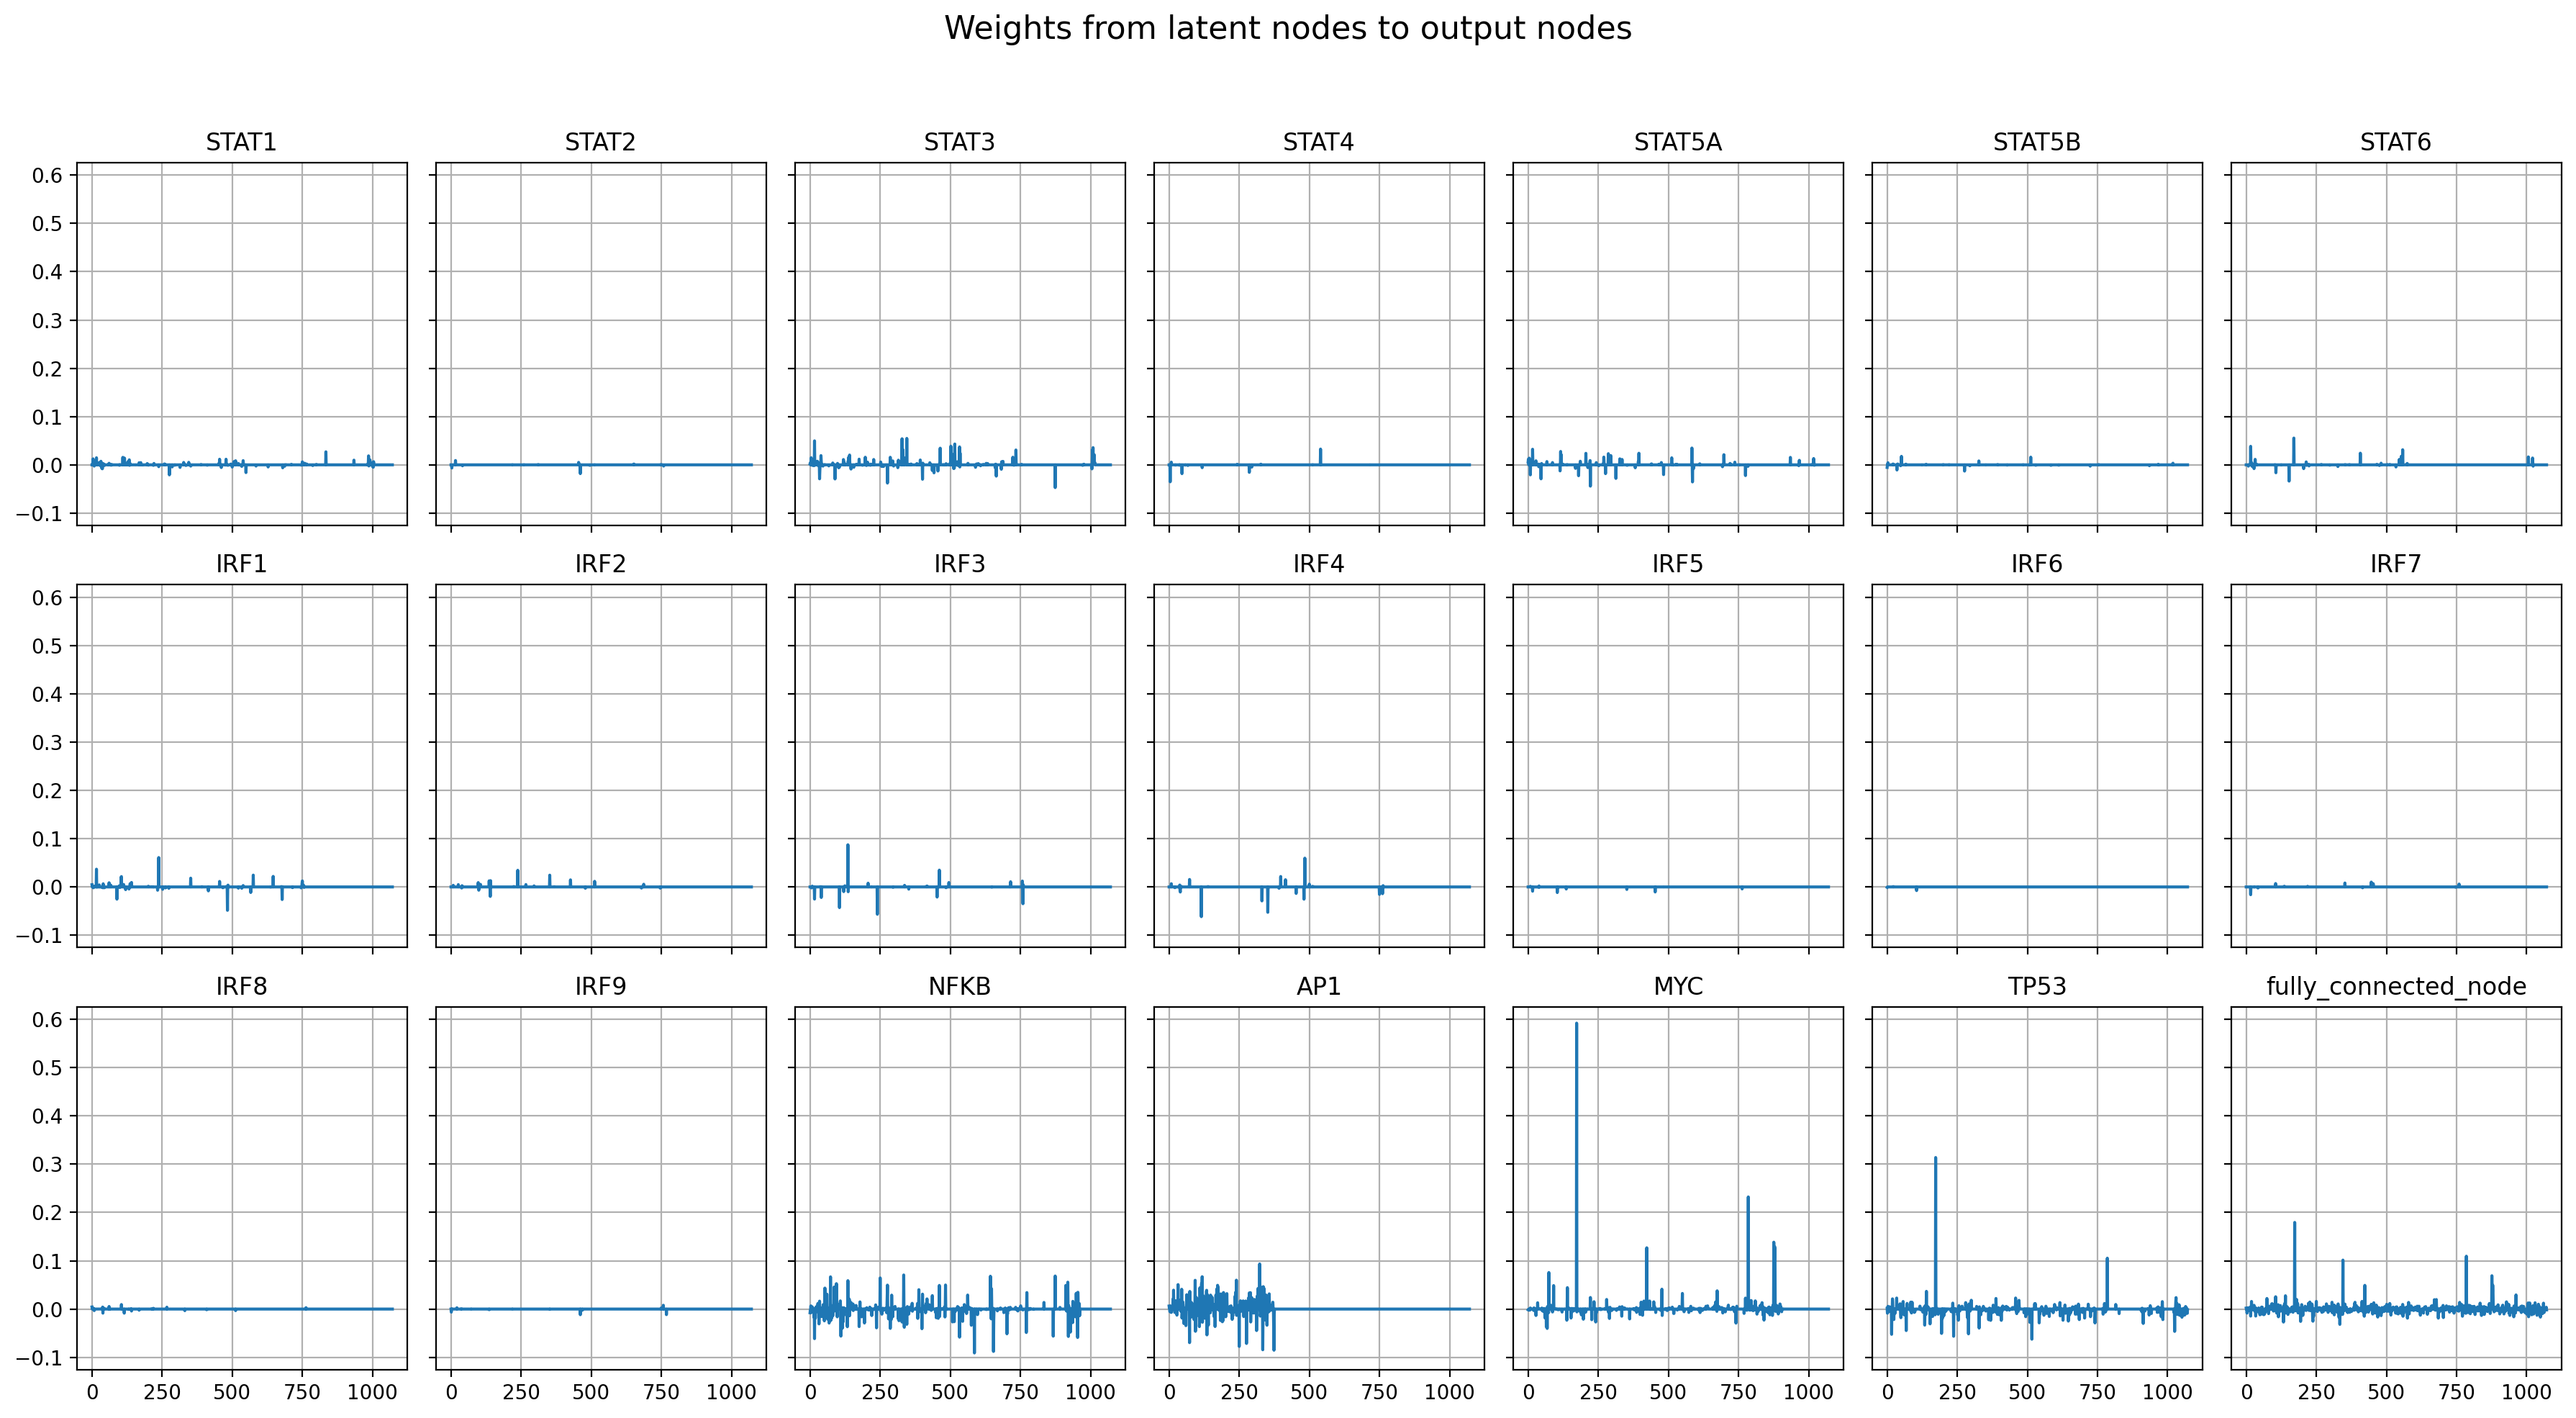

In [70]:
import matplotlib.pyplot as plt

# Get the decoder weights
weights = vega_ctr.state_dict()["decoder.sparse_layer.0.weight"]  # shape: [input_dim, latent_dim]

num_latent = 21
num_cols = 7  # You can adjust this for layout
num_rows = (num_latent + num_cols - 1) // num_cols  # Automatically calculate rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 10), sharex=True, sharey=True)

selected_tfs  = ["STAT1", "STAT2", "STAT3","STAT4","STAT5A","STAT5B","STAT6","IRF1","IRF2","IRF3","IRF4","IRF5","IRF6","IRF7","IRF8","IRF9","NFKB","AP1","MYC","TP53", "fully_connected_node"]

for i in range(num_latent):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]

    weights_from_z = weights[:, i].cpu().numpy()
    ax.plot(weights_from_z)
    ax.set_title(selected_tfs[i]) # assign names
    ax.grid(True)

# Hide unused subplots (if any)
for j in range(num_latent, num_rows * num_cols):
    fig.delaxes(axes[j // num_cols, j % num_cols])

fig.suptitle('Weights from latent nodes to output nodes', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## 7: Investigate the "confidence" of individual TFs

In [73]:
# Train the model many times, save weights in between
for i in range(2, 10):  # try first 1,2 -> rerun -> change number so no overdrive!!!
  vega_ctr = VEGA(latent_dims= filtered_mask_ctr.shape[1], input_dims = filtered_mask_ctr.shape[0], mask = filtered_mask_ctr.T, z_dropout = 0.1, dropout = 0.2).to(device) # input_dim should be the
# model training
  vega_ctr, vega_losses_ctr, vega_klds_ctr, vega_mses_ctr = trainVEGA(vega_ctr, PBMC_controlX,epochs = 40, beta = 0.00001) #takes about 2 mins on GPU # change beta!!!
  torch.save(vega_ctr.state_dict(), f'/content/drive/MyDrive/WORK/Turing Project/Interpretable_VAE/model_weights/weights_ctr_train_{i}.pth')



epoch:  0  loss:  201.13206
epoch:  1  loss:  92.02942
epoch:  2  loss:  76.12006
epoch:  3  loss:  76.97031
epoch:  4  loss:  83.07055
epoch:  5  loss:  79.15486
epoch:  6  loss:  77.99254
epoch:  7  loss:  77.811424
epoch:  8  loss:  76.91966
epoch:  9  loss:  76.87335
epoch:  10  loss:  76.30152
epoch:  11  loss:  76.21895
epoch:  12  loss:  75.67936
epoch:  13  loss:  75.98078
epoch:  14  loss:  75.74975
epoch:  15  loss:  75.99406
epoch:  16  loss:  75.1258
epoch:  17  loss:  74.52438
epoch:  18  loss:  74.24608
epoch:  19  loss:  74.12095
epoch:  20  loss:  73.863205
epoch:  21  loss:  73.72051
epoch:  22  loss:  73.724434
epoch:  23  loss:  73.60806
epoch:  24  loss:  73.468155
epoch:  25  loss:  73.451935
epoch:  26  loss:  73.31726
epoch:  27  loss:  73.201
epoch:  28  loss:  70.72614
epoch:  29  loss:  69.90544
epoch:  30  loss:  65.965065
epoch:  31  loss:  65.43909
epoch:  32  loss:  66.64103
epoch:  33  loss:  64.80513
epoch:  34  loss:  64.96905
epoch:  35  loss:  64.5910